In [2]:
import re
import os
import json 

import spacy
from spacy import displacy

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

STOP_WORDS = stopwords.words('english')

In [80]:
import sys
sys.path.append('../scripts')
from utils import predict, predict_multi_line_text, load_data

sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [3]:
# from importlib import reload

# import utils
# reload(utils)

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [9]:
from transformers import TFBertModel
from transformers import BertTokenizer

In [6]:
data_dir = "../data/bio_data_files"

In [8]:
bio_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]

## Model parameters

In [20]:
EMBEDDING_DIM = 200
MAX_LENGTH = 100

In [21]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [39]:
# initialize lists for input sequences and labels
input_sequences = []
labels = []

# loop through each file
for file_path in bio_files:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # initialize list for current sequence and labels
        sequence = []
        sequence_labels = []
        # loop through each line in the file
        for line in lines:
            line = line.strip()
            if line:
                # tokenize current word
                word = line.split('\t')[0]
                tokenized_word = tokenizer.tokenize(word)
                if tokenized_word:
                    # add tokenized word to current sequence
                    sequence.extend(tokenized_word)
                    # add label for each subword in tokenized word
                    label = line.split('\t')[1]
                    sequence_labels.append(label)
                    for i in range(1, len(tokenized_word)):
                        if label == 'O':
                            sequence_labels.append(label)
                        else:
                            sequence_labels.append(f"I-{label[2:]}")
            else:
                # add current sequence and labels to input sequences and labels
                input_sequences.append(sequence)
                labels.append(sequence_labels)
                # reset sequence and sequence_labels lists
                sequence = []
                sequence_labels = []


In [42]:
unique_labels = set(element for sublist in labels for element in sublist)

label_to_index = {label: id+1 for id, label in enumerate(sorted(unique_labels))}
index_to_label = {id: label for label, id in label_to_index.items()}

# Add the new label and ID to the dictionaries
label_to_index['<PAD>'] = 0
index_to_label[0] = '<PAD>'


In [44]:
len(unique_labels)

79

In [48]:

# pad input sequences and labels
padded_sequences = pad_sequences([tokenizer.convert_tokens_to_ids(seq) for seq in input_sequences], maxlen=MAX_LENGTH, padding='post')
padded_labels = pad_sequences(
    [[label_to_index[label] for label in seq] for seq in labels], 
    maxlen=MAX_LENGTH, padding='post')
padded_labels = to_categorical(padded_labels, num_classes=len(label_to_index))

# train_labels = [[label_to_index[label] for label in all_labels] for all_labels in labels]
# train_labels = pad_sequences(train_labels, maxlen=MAX_LENGTH, padding='post', value=NUM_CLASSES-1)
# train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)

# create attention masks
attention_masks = np.where(padded_sequences != 0, 1, 0)


In [49]:
padded_sequences.shape, padded_labels.shape

((4341, 100), (4341, 100, 80))

## FineTuning Bert Model

In [53]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
bert_output = bert_model(input_ids, attention_mask=attention_masks, return_dict=True)
embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(80, activation='softmax'))(embedding)
model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [54]:
history = model.fit(
    x=[padded_sequences, attention_masks],
    y=padded_labels,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/5
123/123 [==============================] - 552s 4s/step - loss: 1.0844 - accuracy: 0.7872 - val_loss: 0.6442 - val_accuracy: 0.8443
Epoch 2/5
123/123 [==============================] - 557s 5s/step - loss: 0.5870 - accuracy: 0.8590 - val_loss: 0.4519 - val_accuracy: 0.8811
Epoch 3/5
123/123 [==============================] - 562s 5s/step - loss: 0.4413 - accuracy: 0.8855 - val_loss: 0.3637 - val_accuracy: 0.9012
Epoch 4/5
123/123 [==============================] - 566s 5s/step - loss: 0.3634 - accuracy: 0.9030 - val_loss: 0.3158 - val_accuracy: 0.9114
Epoch 5/5
123/123 [==============================] - 545s 4s/step - loss: 0.3164 - accuracy: 0.9137 - val_loss: 0.2880 - val_accuracy: 0.9189


In [85]:
test_attention_masks = np.where(padded_sequences != 0, 1, 0)
results = model.evaluate(
    x=[padded_sequences, attention_masks],
    y=padded_labels,
    batch_size=32
)
print("test loss, test acc:", results)


136/136 [==============================] - 197s 1s/step - loss: 0.2564 - accuracy: 0.9285
test loss, test acc: [0.25636425614356995, 0.9285141825675964]


In [84]:
from transformers import BertTokenizer
import numpy as np

# input sentence
input_sentence = "On the first hospital day, an intercostal drainage tube was inserted, and after drainage, chest computed tomography (CT) (Fig.2) revealed an irregular pleural mass invading her left chest wall with rib destruction and pleural effusion."

# tokenize input sentence
tokens =  []
for t in tokenize_text(input_sentence):
    tokenized_word = tokenizer.tokenize(t)
    for token in tokenized_word:
        tokens.append(token)
padded_sequence = pad_sequences(
    [[tokenizer.convert_tokens_to_ids(seq) for seq in tokens]], 
    maxlen=MAX_LENGTH, padding='post')
# # sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
# # padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')
print(padded_sequence.shape)

# sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
# padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')

# create attention mask
attention_mask = np.where(padded_sequence != 0, 1, 0)

# get predicted NER tags
predictions = model.predict([padded_sequence, attention_mask])

# decode predictions
predicted_labels = np.argmax(predictions, axis=-1)
print(predicted_labels)
predicted_labels = [index_to_label[i] for i in predicted_labels[0]]
# decode predicted tags

for token, label in zip(tokens, predicted_labels):
    if label == 'O':
        print(f"{token} {label}")
    else:
        print(f"{token} {acronyms_to_entities[label[2:]]}")
   


(1, 100)
1/1 [==============================] - 0s 99ms/step
[[79 10 10  6 45 45 36 75  6  6 45 12 51 51 51 51 51 79 11 33 72 72 72 79
   6 45 45 45 45 33 52 72 33 72 72  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
first O
hospital Date
day Date
inter Biological_structure
##cos Biological_structure
##tal Biological_structure
drainage Therapeutic_procedure
tube Therapeutic_procedure
inserted Biological_structure
drainage Biological_structure
chest Biological_structure
computed Diagnostic_procedure
tom Diagnostic_procedure
##ography Diagnostic_procedure
ct Diagnostic_procedure
fig Diagnostic_procedure
##2 Diagnostic_procedure
revealed O
irregular Detailed_description
pl Sign_symptom
##eur Sign_symptom
##al Sign_symptom
mass Sign_symptom
invading O
left Biological_structure
chest Biological_structure
wall Biological_structure
rib Bio

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['train', 'val'], loc='best')

    plt.tight_layout()
    plt.show()


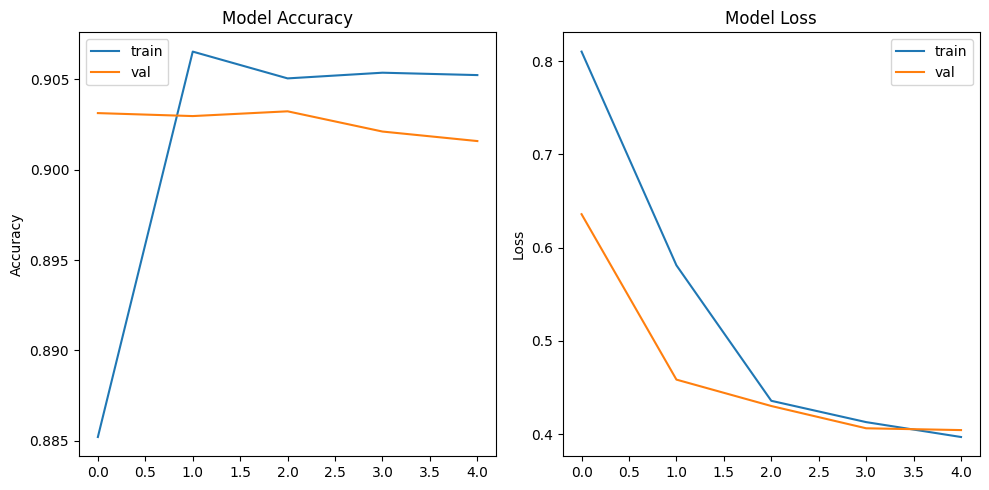

In [23]:
# Plot the training history
plot_graphs(history)